**Requirements:**
1. Our data 'stringer_spontaneous.npy' should be in the same folder with this .ipynb file
2. numpy & pandas & matplotlib & sklearn & seaborn should be installed in your local computer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#@title Data loading
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

### Data Analysis Contents
* Dimensionality Reduction by PCA
* Use Lasso Regression to Predict Running Speed
* Use Ridge Regression to Predict Running Speed
* Use Lasso Regression to Predict Pupil Area
* Use Ridge Regression to Predict Pupil Area
* Compare Coefficients of Lasso & Ridge Models Predicting Running Speed & Pupil Area Respectively

### Dimensionality Reduction by PCA

In [3]:
neuron_data = dat['sresp'].T  # 7018*11983, type is np.ndarray

What need to be reduced is the number of neurons, not the number of timebins, so input data should be the transpose of dat['sresp'].

#### Figure Out Which K to Choose

In [18]:
X = neuron_data - neuron_data.mean(axis=0)

In [19]:
cov_matrix = (X.T@X) / X.shape[0]

In [24]:
evals, evectors = np.linalg.eigh(cov_matrix)

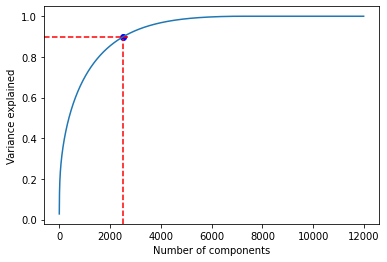

In [236]:
index = np.flip(np.argsort(evals))
explained_sum = np.cumsum(evals[index])
explained_sum_ratio = explained_sum / explained_sum.max()

plt.figure()
plt.plot(np.arange(1, len(explained_sum_ratio) + 1), explained_sum_ratio)
plt.xlabel('Number of components')
plt.ylabel('Variance explained')
plt.axhline(0.9, xmin=0, xmax=0.25, linestyle='--', color='r')
plt.axvline(2525, ymin=0, ymax=0.85, linestyle='--', color='r')
plt.scatter(2525, explained_sum_ratio[2525], color='b')
plt.show()

In [41]:
# select the first K whose corresponding variance explained >= variance_explained_threshold
variance_explained_threshold = 0.9
k_explain = np.argwhere(explained_sum_ratio>=variance_explained_threshold)
k_chosen = k_explain[0][0]
print('k_chosen:', k_chosen)

k_chosen: 2525


In [4]:
# k_chosen = 2525

#### Dimensionality Reduction Using k_chosen Components

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k_chosen)
neuron_data_reduced = pca.fit_transform(neuron_data)
components = pca.components_  # the weights (new basis)

In [6]:
print('The shape of the reduced data is:', neuron_data_reduced.shape)
print('The shape of the k_chosen components is:', components.shape)

The shape of the reduced data is: (7018, 2525)
The shape of the k_chosen components is: (2525, 11983)


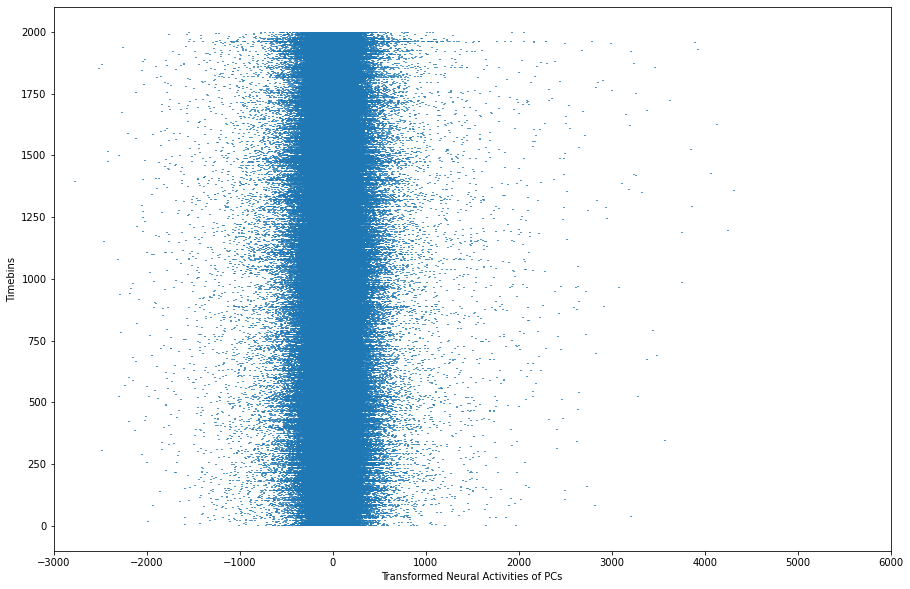

In [46]:
idx = np.arange(len(neuron_data_reduced))
np.random.shuffle(idx)

plt.figure(figsize=(15,10))
plt.eventplot(neuron_data_reduced[:2000])
plt.xlabel('Transformed Neural Activities of PCs')
plt.ylabel('Timebins')
plt.xlim((-3000,6000))
plt.show()

We can now use *neuron_data_reduced* $(7018*2525)$ to do further analysis.

#### Preprocessing Methods

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler_run = MinMaxScaler()
scaler_pupil = MinMaxScaler()

### Use Lasso Regression to Predict Running Speed

#### split the dataset into training set and testing set

In [141]:
X = neuron_data_reduced
y_run = scaler_run.fit_transform(dat['run'])

from sklearn.model_selection import train_test_split
X_train_run, X_test_run, y_train_run, y_test_run = train_test_split(X, y_run, test_size=0.3, random_state=0)
print('Number of data samples in X_train:', len(X_train_run))
print('Number of data samples in X_test:', len(X_test_run))

Number of data samples in X_train: 4912
Number of data samples in X_test: 2106


#### use training set to fit lasso model and test prediction performance on testing set

In [144]:
from sklearn import linear_model
lasso_run = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
lasso_run.fit(X_train_run, y_train_run)
y_pred_lasso_run = lasso_run.predict(X_test_run)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred_lasso_run, y_test_run))

Prediction MSE: 0.0032729168344218396


In [145]:
running_coef_lasso = lasso_run.coef_

#### plot the actual and predicted running speed of the testing set

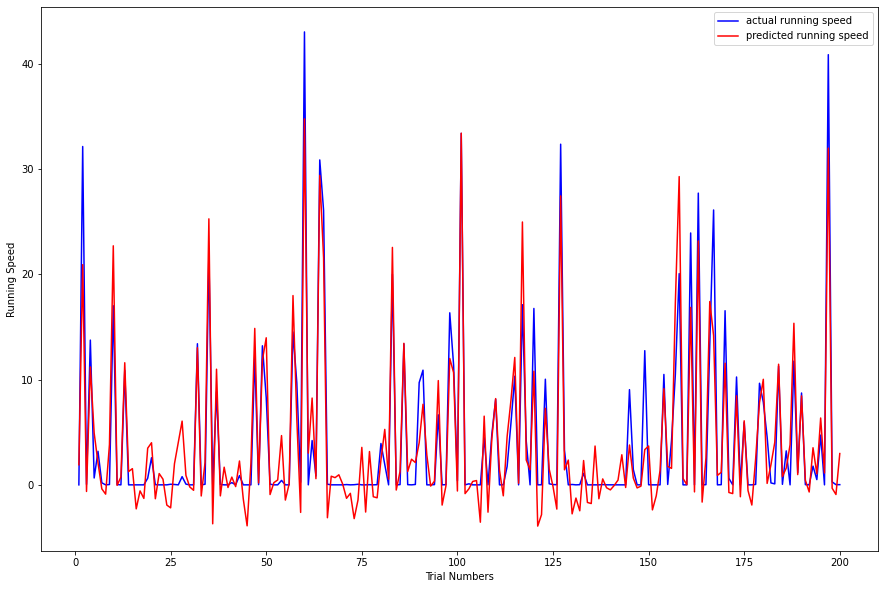

In [155]:
# plot the first n actual and predicted data points
y_test_run_ori = scaler_run.inverse_transform(y_test_run.reshape(-1,1))
y_pred_lasso_run_ori = scaler_run.inverse_transform(y_pred_lasso_run.reshape(-1,1))

n = 200
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y_test_run_ori[:n])+1), y_test_run_ori[:n], 'b-', label='actual running speed')
plt.plot(range(1,len(y_pred_lasso_run_ori[:n])+1), y_pred_lasso_run_ori[:n], 'r-', label='predicted running speed')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Running Speed')
plt.show()

#### plot the predicted running speed against the actual running speed

In [158]:
running_speed = pd.DataFrame()
running_speed['Predicted Running Speed'] = y_pred_lasso_run_ori[:,0]
running_speed['Actual Running Speed'] = y_test_run_ori[:,0]
running_speed.head()

,Predicted Running Speed,Actual Running Speed
0,1.909197,0.000000
1,20.932291,32.166114
2,-0.628770,0.045487
3,11.207036,13.762348
4,4.921647,0.653538


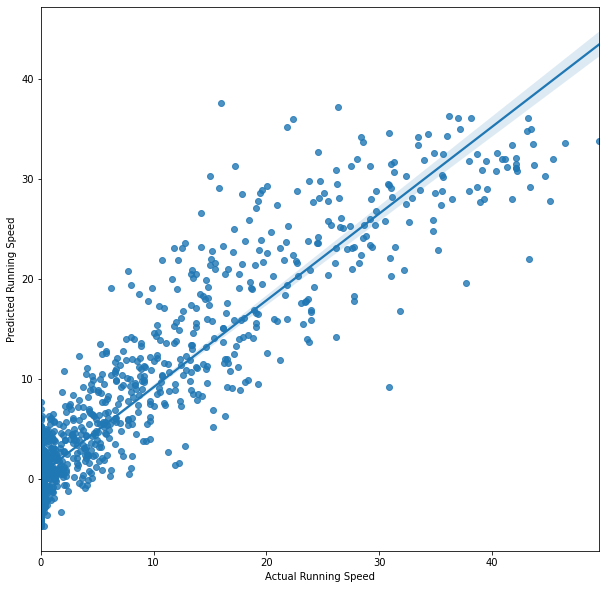

The r2 score is: 0.8617210742743375


In [237]:
from sklearn.metrics import r2_score
plt.figure(figsize = (10,10))
sns.regplot(x="Actual Running Speed", y="Predicted Running Speed", data=running_speed, ci=95)
plt.show()
print('The r2 score is:', r2_score(y_test_run_ori[:,0], y_pred_lasso_run_ori[:,0]))

### Use Ridge Regression to Predict Running Speed

#### use training set to fit Ridge model and test prediction performance on testing set

In [160]:
from sklearn import linear_model
ridge_run = linear_model.Ridge(alpha=0.1)  # select Ridge to make the predictions across timebins smoother
ridge_run.fit(X_train_run, y_train_run)
y_pred_ridge_run = ridge_run.predict(X_test_run)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred_ridge_run, y_test_run))

Prediction MSE: 0.00598955321221907


In [161]:
running_coef_ridge = ridge_run.coef_

#### plot the actual and predicted running speed of the testing set

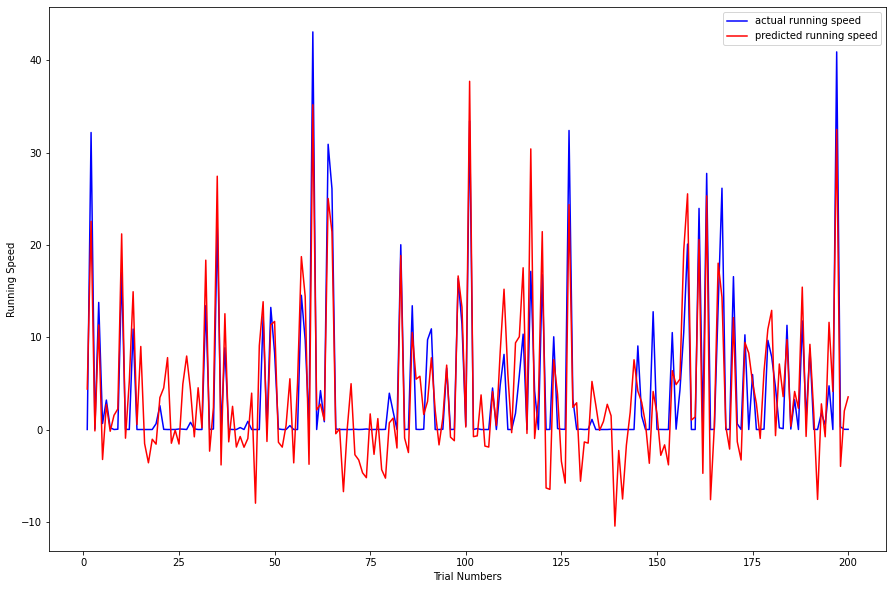

In [162]:
# plot the first n actual and predicted data points
y_test_run_ori = scaler_run.inverse_transform(y_test_run.reshape(-1,1))
y_pred_ridge_run_ori = scaler_run.inverse_transform(y_pred_ridge_run.reshape(-1,1))

n = 200
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y_test_run_ori[:n])+1), y_test_run_ori[:n], 'b-', label='actual running speed')
plt.plot(range(1,len(y_pred_ridge_run_ori[:n])+1), y_pred_ridge_run_ori[:n], 'r-', label='predicted running speed')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Running Speed')
plt.show()

#### plot the predicted running speed against the actual running speed

In [163]:
running_speed_ridge = pd.DataFrame()
running_speed_ridge['Predicted Running Speed'] = y_pred_ridge_run_ori[:,0]
running_speed_ridge['Actual Running Speed'] = y_test_run_ori[:,0]
running_speed_ridge.head()

,Predicted Running Speed,Actual Running Speed
0,4.378021,0.000000
1,22.546600,32.166114
2,-0.152837,0.045487
3,11.326551,13.762348
4,-3.247606,0.653538


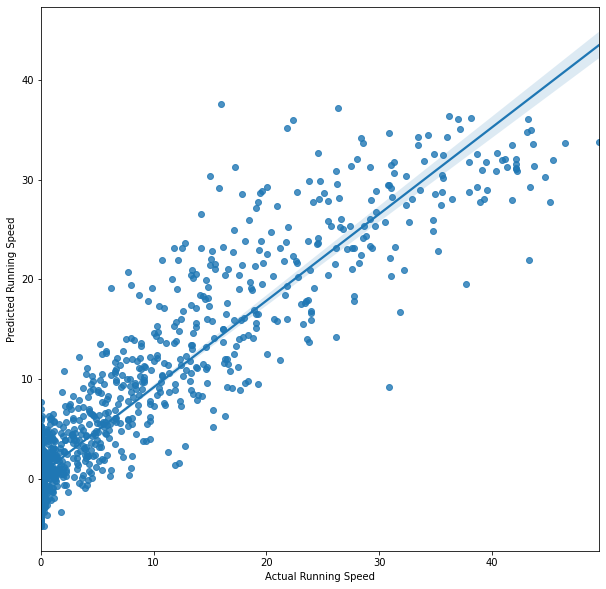

The r2 score is: 0.746944693825


In [238]:
plt.figure(figsize = (10,10))
sns.regplot(x="Actual Running Speed", y="Predicted Running Speed", data=running_speed, ci=95)
plt.show()
print('The r2 score is:', r2_score(y_test_run_ori[:,0], y_pred_ridge_run_ori[:,0]))

In [165]:
print('The MSE between Lasso Prediction and Ridge Prediction',mean_squared_error(y_pred_ridge_run, y_pred_lasso_run))

The MSE between Lasso Prediction and Ridge Prediction 0.002924386


We can see that the predictions from Lasso and Ridge are quite similar.

### Use Lasso Regression to Predict Pupil Area

#### use training set to fit lasso model and test prediction performance on testing set

In [166]:
X = neuron_data_reduced
y_pupil = scaler_pupil.fit_transform(dat['pupilArea'])

from sklearn.model_selection import train_test_split
X_train_pupil, X_test_pupil, y_train_pupil, y_test_pupil = train_test_split(X, y_pupil, test_size=0.3, random_state=0)
print('Number of data samples in X_train:', len(X_train_pupil))
print('Number of data samples in X_test:', len(X_test_pupil))

Number of data samples in X_train: 4912
Number of data samples in X_test: 2106


#### use training set to fit lasso model and test prediction performance on testing set

In [167]:
from sklearn import linear_model
lasso_pupil = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
lasso_pupil.fit(X_train_pupil, y_train_pupil)
y_pred_lasso_pupil = lasso_pupil.predict(X_test_pupil)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred_lasso_pupil, y_test_pupil))

Prediction MSE: 0.003370638197366703


In [168]:
pupil_coef_lasso = lasso_pupil.coef_

#### plot the actual and predicted pupil area of the testing set

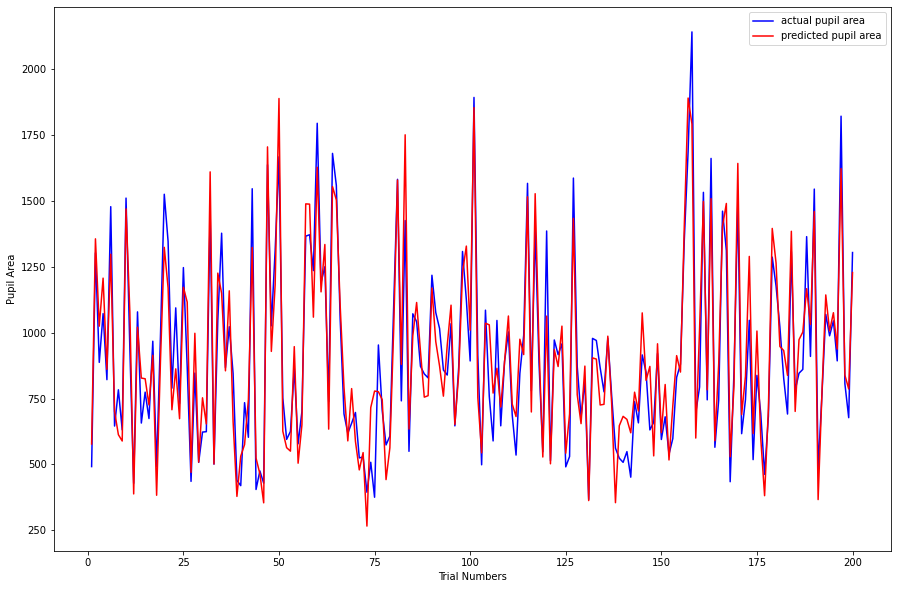

In [173]:
# plot the first n actual and predicted data points
y_test_pupil_ori = scaler_pupil.inverse_transform(y_test_pupil.reshape(-1,1))
y_pred_lasso_pupil_ori = scaler_pupil.inverse_transform(y_pred_lasso_pupil.reshape(-1,1))

n = 200
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y_test_pupil_ori[:n])+1), y_test_pupil_ori[:n], 'b-', label='actual pupil area')
plt.plot(range(1,len(y_pred_lasso_pupil_ori[:n])+1), y_pred_lasso_pupil_ori[:n], 'r-', label='predicted pupil area')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Pupil Area')
plt.show()

#### plot the predicted pupil area against the actual pupil area

In [174]:
pupil_area = pd.DataFrame()
pupil_area['Predicted Pupil Area'] = y_pred_lasso_pupil_ori[:,0]
pupil_area['Actual Pupil Area'] = y_test_pupil_ori[:,0]
pupil_area.head()

,Predicted Pupil Area,Actual Pupil Area
0,577.873108,492.055471
1,1356.412354,1303.048801
2,1025.030518,887.561036
3,1207.199707,1072.567504
4,861.203186,821.928377


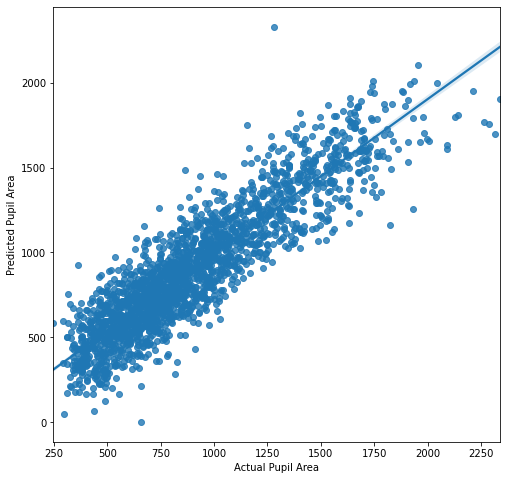

The r2 score is: 0.8753723108030756


In [239]:
plt.figure(figsize = (8,8))
sns.regplot(x="Actual Pupil Area", y="Predicted Pupil Area", data=pupil_area, ci=95)
plt.show()
print('The r2 score is:', r2_score(y_test_pupil_ori[:,0], y_pred_lasso_pupil_ori[:,0]))

### Use Ridge Regression to Predict Pupil Area

#### use training set to fit lasso model and test prediction performance on testing set

In [176]:
from sklearn import linear_model
ridge_pupil = linear_model.Ridge(alpha=0.1)  # select LASSO to further reduce features
ridge_pupil.fit(X_train_pupil, y_train_pupil)
y_pred_ridge_pupil = ridge_pupil.predict(X_test_pupil)

from sklearn.metrics import mean_squared_error
print('Prediction MSE:', mean_squared_error(y_pred_ridge_pupil, y_test_pupil))

Prediction MSE: 0.00536887220247873


In [177]:
pupil_coef_ridge = ridge_pupil.coef_

#### plot the actual and predicted pupil area of the testing set

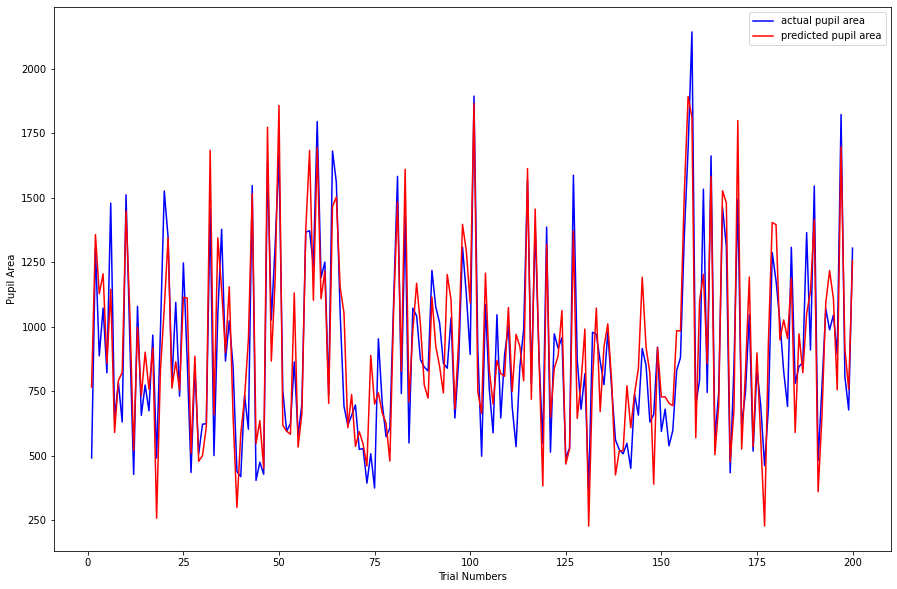

In [178]:
# plot the first n actual and predicted data points
y_test_pupil_ori = scaler_pupil.inverse_transform(y_test_pupil.reshape(-1,1))
y_pred_ridge_pupil_ori = scaler_pupil.inverse_transform(y_pred_ridge_pupil.reshape(-1,1))

n = 200
plt.figure(figsize=(15,10))
plt.plot(range(1,len(y_test_pupil_ori[:n])+1), y_test_pupil_ori[:n], 'b-', label='actual pupil area')
plt.plot(range(1,len(y_pred_ridge_pupil_ori[:n])+1), y_pred_ridge_pupil_ori[:n], 'r-', label='predicted pupil area')
plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('Pupil Area')
plt.show()

#### plot the predicted pupil area against the actual pupil area

In [179]:
pupil_area = pd.DataFrame()
pupil_area['Predicted Pupil Area'] = y_pred_ridge_pupil_ori[:,0]
pupil_area['Actual Pupil Area'] = y_test_pupil_ori[:,0]
pupil_area.head()

,Predicted Pupil Area,Actual Pupil Area
0,767.047852,492.055471
1,1357.061768,1303.048801
2,1128.178345,887.561036
3,1205.151611,1072.567504
4,859.354614,821.928377


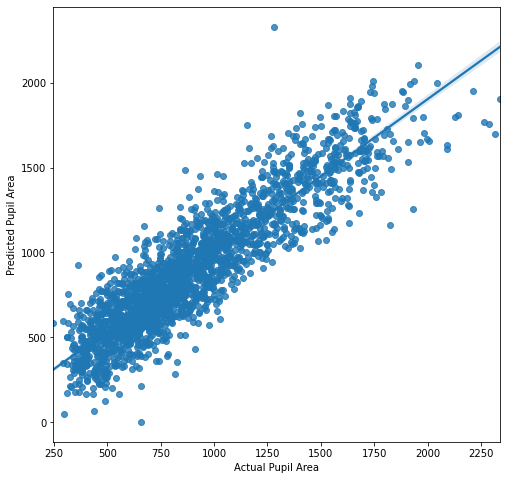

The r2 score is: 0.8014885936070069


In [240]:
plt.figure(figsize = (8,8))
sns.regplot(x="Actual Pupil Area", y="Predicted Pupil Area", data=pupil_area, ci=95)
plt.show()
print('The r2 score is:', r2_score(y_test_pupil_ori[:,0], y_pred_ridge_pupil_ori[:,0]))

### Compare Coefficients of Running Speed and Pupil Area Prediction Model

#### Lasso Prediction Model

In [220]:
coefs_lasso = pd.DataFrame()
index_not_zero = (running_coef_lasso!=0) & (pupil_coef_lasso!=0)  # remove zero coefs to better observe distribution
index_zero = (running_coef_lasso!=0) | (pupil_coef_lasso!=0)
coefs_lasso['Coefficients for Predicting Running Speed in Lasso Model'] = running_coef_lasso[index_not_zero]
coefs_lasso['Coefficients for Predicting Pupil Area in Lasso Model'] = pupil_coef_lasso[index_not_zero]
coefs_lasso.head()

,Coefficients for Predicting Running Speed in Lasso Model,Coefficients for Predicting Pupil Area in Lasso Model
0,8.394047e-05,0.000076
1,-3.626621e-06,0.000049
2,-2.450646e-07,0.000007
3,-1.676184e-05,-0.000013
4,2.059469e-05,0.000003


<Figure size 432x288 with 0 Axes>

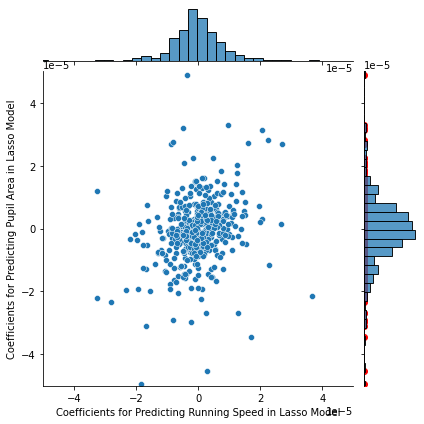

In [221]:
plt.figure()
sns.jointplot(x='Coefficients for Predicting Running Speed in Lasso Model', y='Coefficients for Predicting Pupil Area in Lasso Model',
              data=coefs_lasso,
              kind='scatter',
              xlim=((-5)*10**-5,5*10**-5),ylim=((-5)*10**-5,5*10**-5),
              marginal_kws=dict(bins=50)
             )
plt.scatter(running_coef_lasso[index_zero], pupil_coef_lasso[index_zero], c='r')
plt.show()

In [252]:
running_coef_lasso_demean = running_coef_lasso - running_coef_lasso.mean()
pupil_coef_lasso_demean = pupil_coef_lasso - pupil_coef_lasso.mean()
corr_lasso = (running_coef_lasso_demean*pupil_coef_lasso_demean).sum() / (running_coef_lasso_demean.std()*pupil_coef_lasso_demean.std()*len(pupil_coef_lasso_demean))
print('The pearson correlation of coefficients (without removing zeros) in Lasso models is:', corr_lasso)

The pearson correlation of coefficients (without removing zeros) in Lasso models is: 0.32382869237285417


#### Ridge Prediction Model

In [247]:
coefs_ridge = pd.DataFrame()
coefs_ridge['Coefficients for Predicting Running Speed in Ridge Model'] = running_coef_ridge[0,:]
coefs_ridge['Coefficients for Predicting Pupil Area in Ridge Model'] = pupil_coef_ridge[0,:]
coefs_ridge.head()

,Coefficients for Predicting Running Speed in Ridge Model,Coefficients for Predicting Pupil Area in Ridge Model
0,8.363221e-05,0.000076
1,-3.388587e-06,0.000049
2,-3.124004e-07,0.000007
3,-1.625875e-05,-0.000013
4,2.094360e-05,0.000003


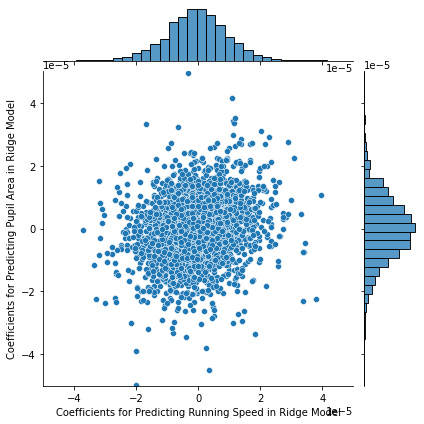

In [248]:
sns.jointplot(x='Coefficients for Predicting Running Speed in Ridge Model', y='Coefficients for Predicting Pupil Area in Ridge Model',
              data=coefs_ridge,
              kind='scatter',
              xlim=((-5)*10**-5,5*10**-5),ylim=((-5)*10**-5,5*10**-5),
              marginal_kws=dict(bins=50)
             )

In [250]:
running_coef_ridge_demean = running_coef_ridge[0,:] - running_coef_ridge[0,:].mean()
pupil_coef_ridge_demean = pupil_coef_ridge[0,:] - pupil_coef_ridge[0,:].mean()
corr_ridge = (running_coef_ridge_demean*pupil_coef_ridge_demean).sum() / (running_coef_ridge_demean.std()*pupil_coef_ridge_demean.std()*len(pupil_coef_ridge_demean))
print('The pearson correlation of coefficients in Ridge models is:', corr_ridge)

The pearson correlation of coefficients in Ridge models is: 0.2229026032704996
